In [85]:
from azure.storage.blob import BlobServiceClient, ContainerClient, BlobPrefix
import cv2
import imageio.v3 as iio
import torch
import torch.nn as nn
from torch.utils.data import Dataset
import torch.nn.functional as F
import torch.optim as optim
from torch.optim.lr_scheduler import MultiStepLR
from PIL import Image
import numpy as np
import random
import os
import matplotlib.pyplot as plt

# Get the directory of the current script file
os.chdir(r'C:\Users\Ecko_\exjobb_jupyter')
print(os.getcwd())

C:\Users\Ecko_\exjobb_jupyter


### Blob Storage Set-up

In [70]:
STORAGEACCOUNTURL = "https://exjobbssl1863219591.blob.core.windows.net"
STORAGEACCOUNTKEY = "PuL1QY8bQvIyGi653lr/9CPvyHLnip+cvsu62YAipDjB7onPDxfME156z5/O2NwY0PRLMTZc86/6+ASt5Vts8w=="
CONTAINERNAME = "exjobbssl"
FOLDERNAME = "UCF-101/ApplyLipstick/"
#BLOBNAME = "UCF-101/ApplyEyeMakeup/v_ApplyEyeMakeup_g01_c01.avi"

blob_service_client_instance = BlobServiceClient(
    account_url=STORAGEACCOUNTURL, credential=STORAGEACCOUNTKEY)

# CALL SPECIFIC BLOB
# #blob_client_instance = blob_service_client_instance.get_blob_client(
#    CONTAINERNAME, BLOBNAME, snapshot=None)
#blob_data = blob_client_instance.download_blob()
#data = blob_data.readall()

container_client_instance = blob_service_client_instance.get_container_client(CONTAINERNAME)
#blob_list = container_client_instance.list_blobs()

### Load Videos Into Memory

In [71]:
class BlobSamples(object):
    def __init__(self):
        self.depth = 0
        self.indent = "  "

    def list_blobs_hierarchical(self, container_client: ContainerClient, prefix):
        for blob in container_client_instance.walk_blobs(name_starts_with=prefix, delimiter='/'):
            if isinstance(blob, BlobPrefix):
                # Indentation is only added to show nesting in the output
                print(f"{self.indent * self.depth}{blob.name}")
                self.depth += 1
                self.list_blobs_hierarchical(container_client_instance, prefix=blob.name)    
                self.depth -= 1
                #print('hi')
            else:
                print(f"{self.indent * self.depth}{blob.name}")

    def load_videos_into_memory(self, blob_service_client: BlobServiceClient, container_name, folder_name, videos_loaded):
        container_client = blob_service_client.get_container_client(container=container_name)

        blob_list = container_client.list_blobs(name_starts_with=folder_name)

        videos = []
        counter = 0  # Add a counter
        for blob in blob_list:
            if counter >= videos_loaded:  # Break the loop after loading 5 videos
                break
            blob_client = blob_service_client.get_blob_client(container=container_name, blob=blob.name)
            video_data = blob_client.download_blob().readall()

            # Create a dictionary for the video
            video = {
                'path': blob.name,  # The path of the video
                'data': video_data  # The bytes data of the video
            }

            videos.append(video)
            counter += 1  # Increment the counter
        return videos

# LIST ALL FOLDERS – Usage of the hierarchical list_blobs function
#sample = BlobSamples()
#sample.list_blobs_hierarchical(container_client_instance, "")

# Usage:
sample = BlobSamples()

videos_loaded = 200
print('loading videos')
videos = sample.load_videos_into_memory(blob_service_client_instance, CONTAINERNAME, FOLDERNAME, videos_loaded)
print('videos loaded')
print("Amount of videos loaded: " + str(len(videos)))

loading videos
videos loaded
Amount of videos loaded: 114


### Read Frame From Blob Storage – OPTIONAL

In [4]:
def read_frames_from_first_n_videos(videos, n):
    for video_data in videos[:n]:  # Only take the first n videos
        frames = iio.imread(video_data, index=None, format_hint=".avi")
        #frames.shape
        # Output:
        #(165 frames, 240x320 pixels, 3 channels)

        frame = frames[0]
        cv2.imshow("image", frame)
        if cv2.waitKey(0) & 0xFF == ord('q'):
            break

    cv2.destroyAllWindows()

# Usage:
amount_of_videos_to_load = 1
#read_frames_from_first_n_videos(videos, amount_of_videos_to_load)

### Prepare Datasets

In [117]:
class PreparedDataset(Dataset):
    def __init__(self, videos, trainval='train'):
        self.video_names_train = []
        self.video_names_test = []
        self.action_labels_train = []
        self.action_labels_test = []
        self.predata_train = []
        self.predata_test = []
        self.videos = videos
        self.trainval = trainval

        # Read the classes file
        with open('classInd.txt', 'r') as f:
            classes = f.readlines()
        classes = [c.strip().split(' ', 1)[1] for c in classes]
        self.class_to_id = {c: i for i, c in enumerate(classes)} #dictionary

        # First, read the paths and labels from the trainlist and testlist files into dictionaries
        train_paths = {}
        test_paths = {}
        with open('trainlist1.txt', 'r') as f:
            for line in f:
                path, label = line.strip().split(' ')
                train_paths[path] = int(label)-1  # Subtract 1 to make the labels 0-indexed
        with open('testlist1.txt', 'r') as f:
            test_paths = {line.strip() for line in f}
        for video in videos:
            path = video['path'][len('UCF-101/'):]  # Remove the 'UCF-101/' prefix from the video path
            video_name = path.split('/')[1].split('.avi')[0].replace('v_', '') #Extracting the name
            if path in train_paths:
                self.video_names_train.append(video_name)
                label = train_paths[path]  # Extract the label from the dictionary
                self.action_labels_train.append(label)
                self.predata_train.append(video)
            elif path in test_paths:
                self.video_names_test.append(video_name)
                class_name = path.split('/')[0]
                label = self.class_to_id[class_name]
                self.action_labels_test.append(label)
                self.predata_test.append(video)

    def __getitem__(self, index):  # https://stackoverflow.com/questions/43627405/understanding-getitem-method-in-python
        if self.trainval == 'train':
            filepath = self.filelist_train[index]
            label = self.action_labels_train[index]
            video = self.predata_train[index]
        else:
            filepath = self.filelist_test[index]
            label = self.action_labels_test[index]
            video = self.predata_test[index]
            
        # Convert the bytes to frames
        #video = iio.imread(video_bytes, index=None, format_hint=".avi")

        return video, label, filepath

    def __len__(self):
        if self.trainval == "train":
            return len(self.predata_train)
        else:
            return len(self.predata_test)

### Train/test Dataset Test

Number of training videos: 82
Number of testing videos: 32
Type of predata_train: <class 'list'>
Length of predata_train: 82
First item of predata_train: {'path': 'UCF-101/ApplyLipstick/v_ApplyLipstick_g08_c01.avi', 'data': b'RIFFT\xd8\x04\x00AVI LIST~"\x00\x00hdrlavih8\x00\x00\x00@\x9c\x00\x00R\xab\x00\x00\x00\x00\x00\x00\x10\x01\x00\x00\xb5\x00\x00\x00\x00\x00\x00\x00\x02\x00\x00\x00\x00\x00\x00\x00@\x01\x00\x00\xf0\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00LIST\x94\x10\x00\x00strlstrh8\x00\x00\x00vidsxvid\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x01\x00\x00\x00\x19\x00\x00\x00\x00\x00\x00\x00\xb5\x00\x00\x00\x87\x1e\x00\x00\x10\'\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00@\x01\xf0\x00strf(\x00\x00\x00(\x00\x00\x00@\x01\x00\x00\xf0\x00\x00\x00\x01\x00\x18\x00XVID\x00\x08\x07\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00JUNK\x18\x10\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00

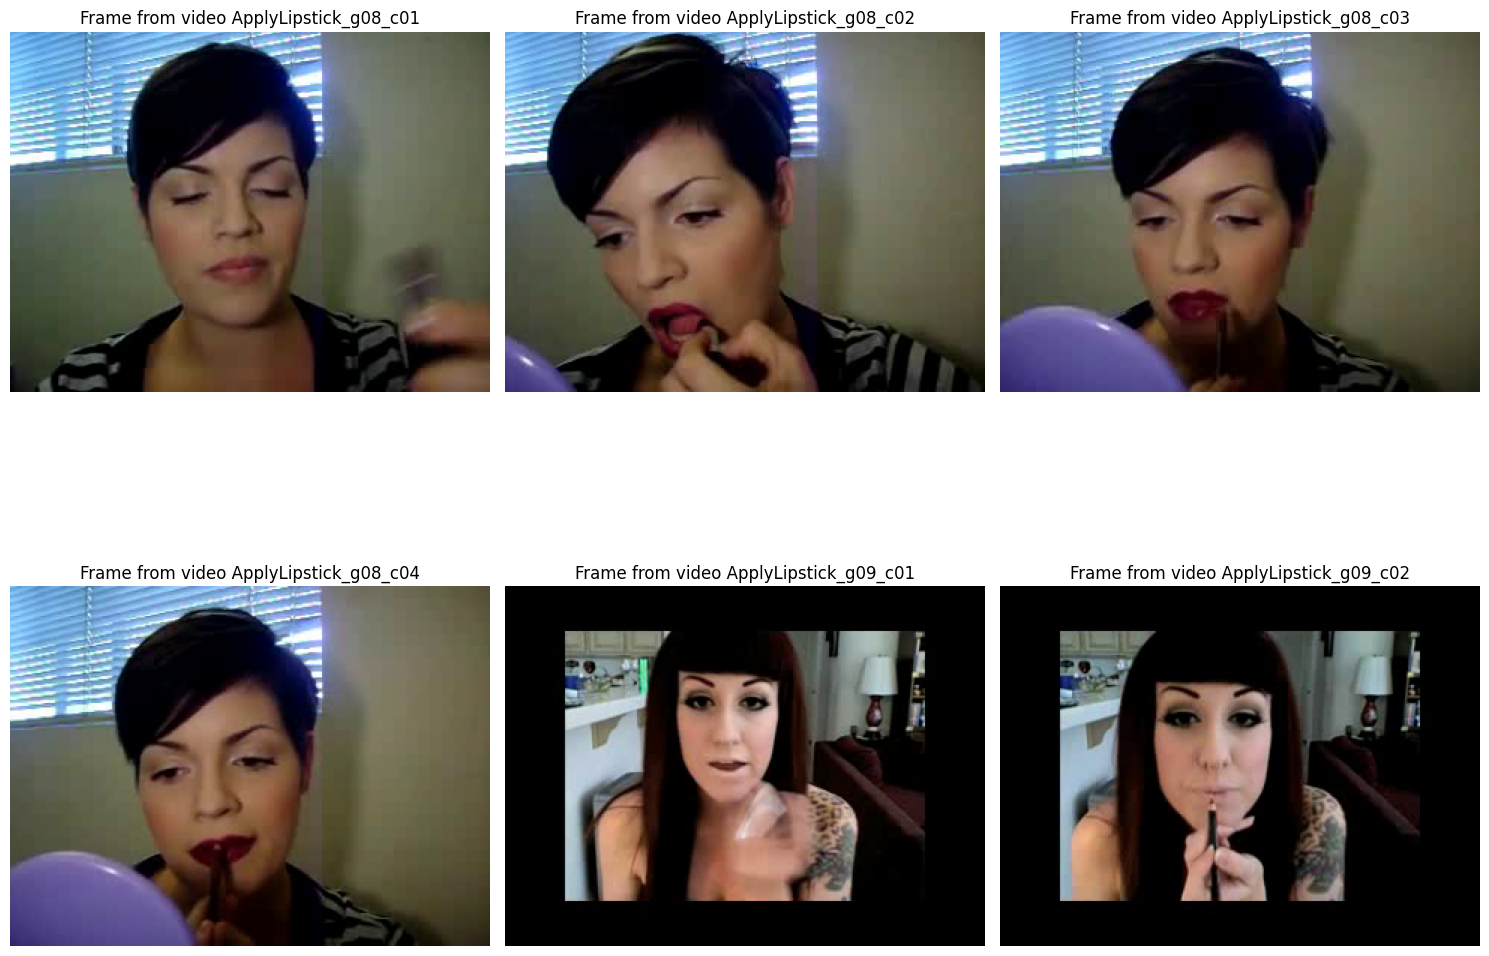

In [120]:
# Initialize the train/test dataset
video_dataset = PreparedDataset(videos, trainval='train')

# Print the first 5 file paths from filelist_train and filelist_test
def test_video_dataset(dataset, n):
    # Print the number of training and testing videos
    print(f"Number of training videos: {len(dataset.predata_train)}")
    print(f"Number of testing videos: {len(dataset.predata_test)}")

    # Print the type of predata_train
    print(f"Type of predata_train: {type(dataset.predata_train)}")

    # If predata_train is a list or a dictionary, print its length
    if isinstance(dataset.predata_train, (list, dict)):
        print(f"Length of predata_train: {len(dataset.predata_train)}")

    # If predata_train is a NumPy array, print its shape
    if isinstance(dataset.predata_train, np.ndarray):
        print(f"Shape of predata_train: {dataset.predata_train.shape}")

    # If predata_train is a list or a dictionary, print the first item to inspect its structure
    if isinstance(dataset.predata_train, (list, dict)):
        print(f"First item of predata_train: {dataset.predata_train[0]}")

    #print(dataset.actionlabels_train[:15])
    #print(dataset.actionlabels_test[:15])

    #print(dataset.video_names_train[:15])
    #print(dataset.video_names_test[:15])

    fig, axs = plt.subplots(nrows=(n+2)//3, ncols=3, figsize=(15, 5*(n+2)//3))

    # Display the first n videos from the training data
    for i, video_data in enumerate(dataset.predata_train[:n]):  # Only take the first n videos from training data
        frames = iio.imread(video_data['data'], index=None, format_hint=".avi")
        frame = frames[0]

        # Display the frame using pyplot
        axs[i//3, i%3].imshow(frame)
        axs[i//3, i%3].set_title(f'Frame from video {dataset.video_names_train[i]}')
        axs[i//3, i%3].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_display = 6
test_video_dataset(video_dataset, amount_of_videos_to_display)

### Image Re-ordering & Preprocessing

<class 'torch.Tensor'>
torch.Size([4, 80, 80, 3])
<class 'torch.Tensor'>
tensor([3, 2, 1, 0])
<class 'torch.Tensor'>
tensor(1)
<class 'str'>
ApplyLipstick_g09_c01
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)
(80, 80, 3)


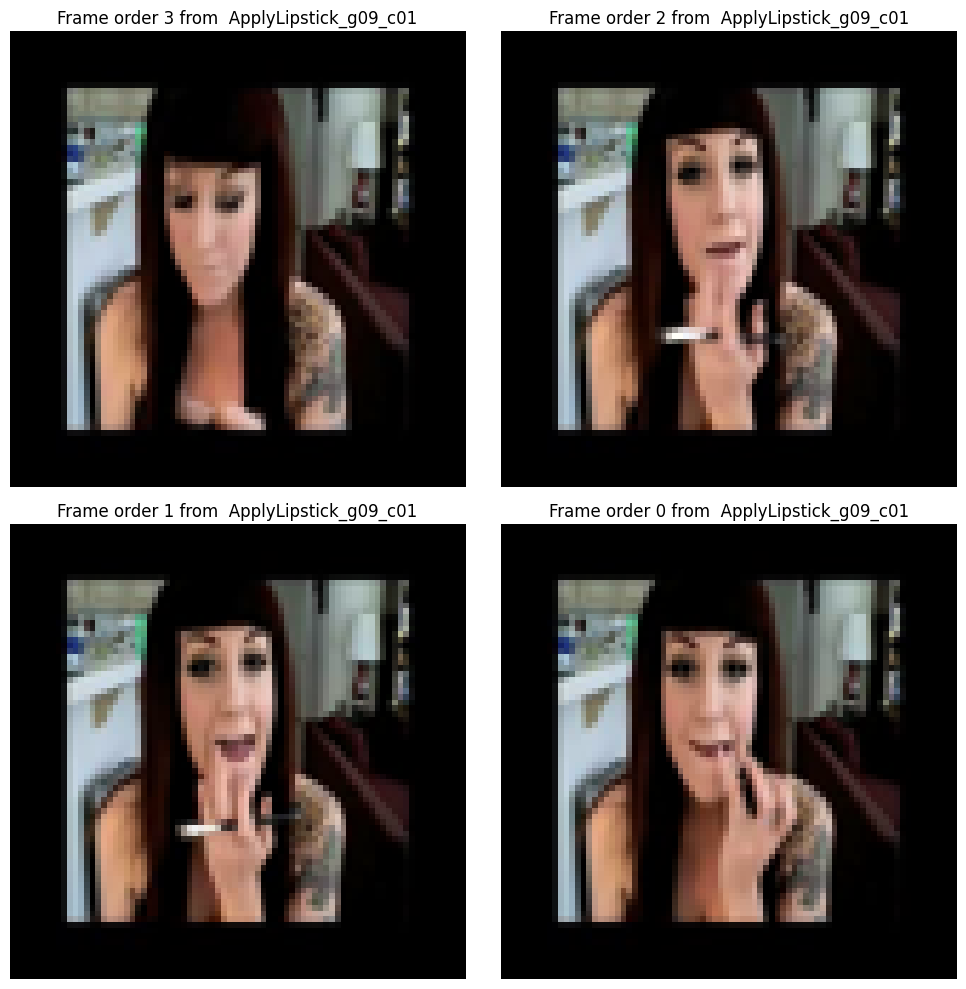

In [127]:
class PreprocessedTemporalFourData(Dataset):
    def __init__(self, dataset, trainval='train', mean=[96.5, 96.5, 96.5], imagesize=80):
        self.dataset = dataset
        self.trainval = trainval
        self.mean = mean
        self.imagesize = imagesize
        
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):
        if self.trainval == 'train':
            video = self.dataset.predata_train[index]
            action_label = self.dataset.action_labels_train[index]
            video_name = self.dataset.video_names_train[index]
        else:
            video = self.dataset.predata_test[index]
            action_label = self.dataset.action_labels_test[index]
            video_name = self.dataset.video_names_test[index]

        # Randomly select 4 frames from the video
        frames = iio.imread(video['data'], index=None, format_hint=".avi")
        indices = np.random.choice(frames.shape[0], size=4, replace=False)
        selected_frames = frames[indices]
        # Normalize the indices to their respective order
        order_indices = indices.argsort().argsort()

        #print(type(selected_frames))
        #print(selected_frames.shape)

        preprocessed_frames = []
        frame_labels = []

        for i, frame in enumerate(selected_frames):
            # Convert the numpy array to an image
            frame = Image.fromarray(frame.astype('uint8'))

            # Resize the frame
            frame = frame.resize((self.imagesize, self.imagesize))

            ## Ensure the frame has three channels
            #frame = frame.convert("RGB")

            # Convert the frame back to a numpy array
            frame = np.array(frame)

            # Subtract the mean
            #frame = frame - self.mean #(TODO check if this is correct)

            # Name & index the frame
            #frame_name = f"im{i+1}" #TODO do I really need the naming? Should I remove it above as well?
            frame_labels.append(order_indices[i])

            #preprocessed_frames = self.preprocess(preprocessed_frames)

            # Convert the frame to a PyTorch tensor and add it to the list
            preprocessed_frames.append(torch.from_numpy(frame))
            
        # Stack all the frames together into a single tensor
        preprocessed_frames = torch.stack(preprocessed_frames)

        # Convert the frame labels to a PyTorch tensor
        frame_labels = torch.tensor(frame_labels)

        # Convert the video label to a PyTorch tensor
        action_label = torch.tensor(action_label)

        return preprocessed_frames, frame_labels, action_label, video_name

    def preprocess(self, video):
        # TODO Sample candidate tuples based on motion magnitude
        #frames = self.sample_frames_based_on_motion(video)

        preprocessed_frames = []
        for frame in frames:
            # Apply spatial jittering
            frame = self.spatial_jitter(frame)

            # Apply channel splitting
            frame = self.channel_split(frame)

            preprocessed_frames.append(frame)

        return preprocessed_frames

    def sample_frames_based_on_motion(self, video):
        # Implement this function based on how you want to sample frames based on motion magnitude
        pass

    def spatial_jitter(self, frame):
        # This is a simplified version of the spatial jittering code in the provided function
        sjx = sjy = self.imagesize  # Assuming the frame is a square
        startx = random.randint(0, frame.size[0]-sjx)
        starty = random.randint(0, frame.size[1]-sjy)
        return frame.crop((startx, starty, startx+sjx, starty+sjy))

    def channel_split(self, frame):
        # This is a simplified version of the channel splitting code in the provided function
        rgb = random.randint(0, 2)
        frame = np.array(frame)[:,:,rgb]
        frame = np.stack((frame,)*3, axis=2)
        return frame

def test_temporal_four(temporal_four, n):
    input_frames, frame_labels, action_label, video_name = temporal_four[4]
    print(type(input_frames))
    #print(preprocessed_frames)
    print(input_frames.shape)
    print(type(frame_labels))
    print(frame_labels)
    print(type(action_label))
    print(action_label)
    print(type(video_name))
    print(video_name)
    
    # Now you can do something with preprocessed_frames, like check its shape
    #print(f"Shape of preprocessed_frames for index {0}: {preprocessed_frames[0][1].shape}")
    fig, axs = plt.subplots(2, 2, figsize=(10, 10))

    for i, (frame) in enumerate(input_frames):
        frame = frame.numpy()
        print(frame.shape)
        
        axs[i//2, i%2].imshow(frame)
        axs[i//2, i%2].set_title(f'Frame order {frame_labels[i]} from  {video_name}')
        axs[i//2, i%2].axis('off')

    plt.tight_layout()
    plt.show()

# Usage:
amount_of_videos_to_load = 6
video_dataset = PreparedDataset(videos, trainval='train')
temporal_four = PreprocessedTemporalFourData(video_dataset, trainval='train')
test_temporal_four(temporal_four, amount_of_videos_to_load)

### Create Validation Set

In [ ]:
# TODO: Implement the split_data function

def split_data(dataset, split_ratio=0.8):
    # Calculate the number of samples in the training set
    train_size = int(split_ratio * len(dataset.predata_train))

    # Split the data
    train_data = dataset.predata_train[:train_size]
    validation_data = dataset.predata_train[train_size:]

    # Split the labels
    train_labels = dataset.action_labels_train[:train_size]
    validation_labels = dataset.action_labels_train[train_size:]

    # Split the video names
    train_video_names = dataset.video_names_train[:train_size]
    validation_video_names = dataset.video_names_train[train_size:]

    return train_data, train_labels, train_video_names, validation_data, validation_labels, validation_video_names

# Usage:
train_data, train_labels, train_video_names, validation_data, validation_labels, validation_video_names = split_data(video_dataset)

### train_opn

In [125]:
class CustomOPN(nn.Module):
    def __init__(self):
        super(CustomOPN, self).__init__()
        self.conv1 = nn.Conv2d(12, 96, kernel_size=11, stride=4, padding=0)
        self.pool1 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm1 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75)
        self.conv2 = nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2, groups=2)
        self.pool2 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.norm2 = nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75)
        self.conv3 = nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(384)
        self.conv4 = nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1, groups=2)
        self.bn4 = nn.BatchNorm2d(384)
        self.conv5 = nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1, groups=2)
        self.bn5 = nn.BatchNorm2d(256)
        self.pool5 = nn.MaxPool2d(kernel_size=3, stride=2)
        self.relu = nn.ReLU(inplace=True)
        self.fc6 = nn.Linear(256 * 6 * 6, 1024)  # Assuming the input size is (256, 6, 6)
        self.bn6 = nn.BatchNorm1d(1024)
        self.relu6 = nn.ReLU(inplace=True)
        self.drop6 = nn.Dropout(0.5)
        self.fc7 = nn.Linear(1024, 512)
        self.fc7_1 = nn.Linear(1024, 512)
        self.bn7_1 = nn.BatchNorm1d(512)
        self.relu7_1 = nn.ReLU(inplace=True)
        self.drop7_1 = nn.Dropout(0.5)
        self.fc7_2 = nn.Linear(1024, 512)
        self.bn7_2 = nn.BatchNorm1d(512)
        self.relu7_2 = nn.ReLU(inplace=True)
        self.drop7_2 = nn.Dropout(0.5)
        self.fc7_3 = nn.Linear(1024, 512)
        self.bn7_3 = nn.BatchNorm1d(512)
        self.relu7_3 = nn.ReLU(inplace=True)
        self.drop7_3 = nn.Dropout(0.5)
        self.fc7_4 = nn.Linear(1024, 512)
        self.bn7_4 = nn.BatchNorm1d(512)
        self.relu7_4 = nn.ReLU(inplace=True)
        self.drop7_4 = nn.Dropout(0.5)
        self.fc7_5 = nn.Linear(1024, 512)
        self.bn7_5 = nn.BatchNorm1d(512)
        self.relu7_5 = nn.ReLU(inplace=True)
        self.drop7_5 = nn.Dropout(0.5)
        self.fc7_6 = nn.Linear(1024, 512)
        self.bn7_6 = nn.BatchNorm1d(512)
        self.relu7_6 = nn.ReLU(inplace=True)
        self.drop7_6 = nn.Dropout(0.5)
        self.fc8 = nn.Linear(512*6, 12)  # 6 is the number of concatenated layers

    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool1(x)
        x = self.norm1(x)
        x = self.conv2(x)
        x = self.relu(x)
        x = self.pool2(x)
        x = self.norm2(x)
        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu(x)
        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu(x)
        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu(x)
        x = self.pool5(x)
        x = x.view(x.size(0), -1)  # Flatten the tensor
        x = self.fc6(x)
        x = self.bn6(x)
        x = self.relu6(x)
        x = self.drop6(x)
        x1, x2, x3, x4 = x.chunk(4, dim=1)  # Slice the tensor into 4 parts
        x_concat_1 = torch.cat((x1, x2), dim=1)
        x_concat_2 = torch.cat((x2, x3), dim=1)
        x_concat_3 = torch.cat((x3, x4), dim=1)
        x_concat_4 = torch.cat((x1, x3), dim=1)
        x_concat_5 = torch.cat((x2, x4), dim=1)
        x_concat_6 = torch.cat((x1, x4), dim=1)
        out1 = self.fc7_1(x_concat_1)
        out1 = self.bn7_1(out1)
        out1 = self.relu7_1(out1)
        out1 = self.drop7_1(out1)
        out2 = self.fc7_2(x_concat_2)
        out2 = self.bn7_2(out2)
        out2 = self.relu7_2(out2)
        out2 = self.drop7_2(out2)
        out3 = self.fc7_3(x_concat_3)
        out3 = self.bn7_3(out3)
        out3 = self.relu7_3(out3)
        out3 = self.drop7_3(out3)
        out4 = self.fc7_4(x_concat_4)
        out4 = self.bn7_4(out4)
        out4 = self.relu7_4(out4)
        out4 = self.drop7_4(out4)
        out5 = self.fc7_5(x_concat_5)
        out5 = self.bn7_5(out5)
        out5 = self.relu7_5(out5)
        out5 = self.drop7_5(out5)
        out6 = self.fc7_6(x_concat_6)
        out6 = self.bn7_6(out6)
        out6 = self.relu7_6(out6)
        out6 = self.drop7_6(out6)
        out = torch.cat((out1, out2, out3, out4, out5, out6), dim=1)  # Concatenate along the channel dimension
        out = self.fc8(out)
        return out
    
#Initialize the model
model = CustomOPN()
criterion = nn.CrossEntropyLoss()

#Setting optimizer and scheduler
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=0.0005)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[10, 20], gamma=0.1) #TODO make it milestones=[130000, 170000]

# Create data loaders
train_loader = torch.utils.data.DataLoader(temporal_four, batch_size=32, shuffle=True)
# Assuming validation_data is your validation dataset
#validation_loader = torch.utils.data.DataLoader(validation_data, batch_size=32, shuffle=False) TODO add validation data

# Training loop
for epoch in range(100):  # max_iter, TODO make it 17000
    # Training phase
    model.train()
    for inputs, frame_labels, action_labels, video_name in train_loader:
        # Convert inputs to float
        inputs = inputs.to(torch.float32)
        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)

        # Calculate loss
        loss = criterion(outputs, frame_labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()
    
    # Every 10000 iterations, save a snapshot of the model
    #if epoch % 10000 == 0:
    #    torch.save({
    #        'epoch': epoch,
    #        'model_state_dict': model.state_dict(),
    #        'optimizer_state_dict': optimizer.state_dict(),
    #        # ... any other state you want to save ...
    #    }, f'snapshot/UCF_4opn_{epoch}.pt')

    # Step the learning rate scheduler

    # Validation phase
    #model.eval()
    #correct = 0
    #total = 0
    #with torch.no_grad():
    #    for inputs, frame_labels, video_labels in validation_loader:
    #        # Convert inputs to float
    #        inputs = inputs.to(torch.float32)
    #        outputs = model(inputs)
    #        _, predicted = torch.max(outputs.data, 1)
    #        total += frame_labels.size(0)
    #        correct += (predicted == frame_labels).sum().item()
    #print(f'Epoch {epoch}, Accuracy: {100 * correct / total}%')

    # Step the learning rate scheduler
    scheduler.step()

RuntimeError: Input type (unsigned char) and bias type (float) should be the same

### solver_opn

### visualize.py

In [ ]:
import sys 
import os
import numpy as np
import os.path as osp 
import scipy.io as sio 
from copy import copy
from PIL import Image
import random
import matplotlib.pyplot as plt
plt.switch_backend('agg')


def sortbyvar(data):
    sortdata = np.zeros(data.shape)
    sumdata = np.sum(data, axis=3)
    flat = sumdata.reshape(sumdata.shape[0], sumdata.shape[1]*sumdata.shape[2])
    std = np.std(flat, axis=1)
    order = np.argsort(std)
    for i in range(order.shape[0]):
        sortdata[i,:,:,:] = data[order[i],:,:,:]
    return sortdata

def vis_square(data, fname):
    """Take an array of shape (n, height, width) or (n, height, width, 3)
       and visualize each (height, width) thing in a grid of size approx. sqrt(n) by sqrt(n)"""
    data = np.squeeze(data)
    # normalize data for display
    data = (data - data.min()) / (data.max() - data.min())
    data = sortbyvar(data)   
 
    # force the number of filters to be square
    n = int(np.ceil(np.sqrt(data.shape[0])))
    padding = (((0, 96 - data.shape[0]),
               (0, 1), (0, 1))                 # add some space between filters
               + ((0, 0),) * (data.ndim - 3))  # don't pad the last dimension (if there is one)
    data = np.pad(data, padding, mode='constant', constant_values=1)  # pad with ones (white)
    
    # tile the filters into an image
    data = data.reshape((6, 16) + data.shape[1:]).transpose((0, 2, 1, 3) + tuple(range(4, data.ndim + 1)))
    data = data.reshape((6 * data.shape[1], 16 * data.shape[3]) + data.shape[4:])
    
    plt.imshow(data); plt.axis('off')
    plt.savefig(fname,bbox_inches='tight')

if __name__ == '__main__':
    """
    usage: visualize.py model output_fig
    """


    caffe_root = '/home/hylee/Unsupervised/caffe_s2/'
    sys.path.append(caffe_root + 'python')
    import caffe
    gpu_id = 0
    caffe.set_mode_gpu()
    caffe.set_device(gpu_id)
    caffemodel = sys.argv[1]
    fname = sys.argv[2]
    prototxt = 'prototxt/deploy_RGB.prototxt'

    conv1 = 'conv1'
    
    net = caffe.Net(prototxt, caffemodel, caffe.TEST)
    filters = net.params[conv1][0].data
    vis_square(filters.transpose(0, 2, 3, 1), fname)